In [32]:
import torch

import clip
from clip.simple_tokenizer import SimpleTokenizer
from clip import clip

In [9]:
# CSC True
model_path_csc = "/users/eleves-a/2022/haiyang.jiang/CV_Proj/repo/CoOp/output/eurosat/CoOp/rn50_16shots/nctx16_cscTrue_ctpend/seed1/prompt_learner/model.pth.tar-200"

In [10]:
# CSC False
model_path_no_csc = "/users/eleves-a/2022/haiyang.jiang/CV_Proj/repo/CoOp/output/eurosat/CoOp/rn50_16shots/nctx16_cscFalse_ctpend/seed1/prompt_learner/model.pth.tar-200"

In [31]:
def construct_input_for_class(class_idx, prompt_learner, csc=False):
    """
    Constructs a modified input embedding tensor for a given class index.
    
    Parameters:
    - class_idx: Index of the class (0 to 9)
    - ctx (csc=False): The context embeddings tensor of shape [16, 512]
    - ctx (csc=True): The context embeddings tensor of shape [10, 16, 512], with each class different context
    - token_prefix: The prefix embeddings tensor of shape [10, 1, 512]
    - token_suffix: The suffix embeddings tensor of shape [10, 60, 512]
    
    Returns:
    - A tensor representing the modified input for the given class
    """

    ctx = prompt_learner['ctx']
    token_prefix = prompt_learner['token_prefix']
    token_suffix = prompt_learner['token_suffix']

    # Selecting prefix and suffix for the class
    selected_prefix = token_prefix[class_idx]  # Shape: [1, 512]
    selected_suffix = token_suffix[class_idx].squeeze(0)  # Shape: [60, 512]
    
    # Concatenating prefix, ctx, and suffix to form the modified input
    if csc:
        modified_input = torch.cat([selected_prefix, ctx[class_idx].squeeze(0), selected_suffix], dim=0)
    else:
        modified_input = torch.cat([selected_prefix, ctx, selected_suffix], dim=0)

    return modified_input


In [33]:
clip_model, preprocess = clip.load("RN50", device="cpu")

In [34]:
tokenizer = SimpleTokenizer()
token_embedding = clip_model.token_embedding.weight
print(f"Size of token embedding: {token_embedding.shape}")

Size of token embedding: torch.Size([49408, 512])


In [36]:
# Tokenize text
text = "fuck!"
text_tokens = clip.tokenize([text]).to("cpu")
print(text_tokens.shape)

torch.Size([1, 77])


In [37]:
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)

print(text_features.shape)

torch.Size([1, 1024])


## No CSC

In [11]:
prompt_learner_no_csc = torch.load(model_path_no_csc, map_location="cpu")["state_dict"]

In [12]:
for key in prompt_learner_no_csc.keys():
    print(key)

ctx
token_prefix
token_suffix


In [13]:
for key, value in prompt_learner_no_csc.items():
    print(f"{key}: {value.size()}")

ctx: torch.Size([16, 512])
token_prefix: torch.Size([10, 1, 512])
token_suffix: torch.Size([10, 60, 512])


In [6]:
ctx_no_csc = prompt_learner_no_csc["ctx"]
ctx_no_csc = ctx_no_csc.float()
print(f"Size of context: {ctx_no_csc.shape}")

Size of context: torch.Size([16, 512])


In [26]:
class_idx = 0  # For class 0

# Construct the input for the specified class
input_for_class = construct_input_for_class(class_idx, prompt_learner_no_csc, csc=False)

print(input_for_class.shape)

torch.Size([1, 512])
torch.Size([60, 512])
torch.Size([77, 512])


## CSC

In [14]:
prompt_learner_csc = torch.load(model_path_csc, map_location="cpu")["state_dict"]

In [15]:
for key in prompt_learner_csc.keys():
    print(key)

ctx
token_prefix
token_suffix


In [16]:
for key, value in prompt_learner_csc.items():
    print(f"{key}: {value.size()}")

ctx: torch.Size([10, 16, 512])
token_prefix: torch.Size([10, 1, 512])
token_suffix: torch.Size([10, 60, 512])


In [27]:
class_idx = 0  # For class 0

# Construct the input for the specified class
input_for_class = construct_input_for_class(class_idx, prompt_learner_csc, csc=True)

print(input_for_class.shape)

torch.Size([1, 512])
torch.Size([60, 512])
torch.Size([77, 512])


## Use DASSL

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

In [35]:
import trainers.coop
import datasets.eurosat

In [36]:
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
from dassl.utils import set_random_seed
from yacs.config import CfgNode as CN

DATA="/Data/CV_Proj/"
TRAINER="CoOp"

DATASET="eurosat"
CFG="rn50"
CTP="end"
NCTX=16
SHOTS=16
CSC=False

SEED=1

python train.py \
--root /Data/CV_Proj \
--seed 1 \
--trainer CoOp \
--dataset-config-file configs/datasets/eurosat.yaml \
--config-file configs/trainers/CoOp/rn50.yaml \
--output-dir output/test \
--model-dir output/eurosat/CoOp/rn50_16shots/nctx16_cscFalse_ctpend/seed1 \
--load-epoch 50 \
--eval-only \
TRAINER.COOP.N_CTX 16 \
TRAINER.COOP.CSC False \
TRAINER.COOP.CLASS_TOKEN_POSITION end \


In [52]:
class Fake_Args:
    def __init__(self, csc=False):
        self.root = "/Data/CV_Proj"
        self.seed = 1
        self.trainer = "CoOp"
        self.dataset_config_file = "configs/datasets/eurosat.yaml"
        self.config_file = "configs/trainers/CoOp/rn50.yaml"
        self.output_dir = "output/test"
        if not csc:
            self.model_dir = "output/eurosat/CoOp/rn50_16shots/nctx16_cscFalse_ctpend/seed1"
        else:
            self.model_dir = "output/eurosat/CoOp/rn50_16shots/nctx16_cscTrue_ctpend/seed1"
        self.load_epoch = 200
        self.eval_only = True
        # Additional specific arguments
        self.n_ctx = 16
        if not csc:
            self.csc = False
        else:
            self.csc = True
        self.class_token_position = "end"



In [53]:
args = Fake_Args(csc=True)

In [54]:
def setup_cfg(args):

    cfg = get_cfg_default()

    # 0. Extend
    cfg.TRAINER.COOP = CN()
    cfg.TRAINER.COOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COOP.CSC = False  # class-specific context
    cfg.TRAINER.COOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COOP.PREC = "fp32"  # fp16, fp32, amp
    cfg.TRAINER.COOP.CLASS_TOKEN_POSITION = "end"  # 'middle' or 'end' or 'front'

    cfg.TRAINER.COCOOP = CN()
    cfg.TRAINER.COCOOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COCOOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COCOOP.PREC = "fp32"  # fp16, fp32, amp

    cfg.DATASET.SUBSAMPLE_CLASSES = "all"  # all, base or new

    cfg.TRAINER.COOP.N_CTX = args.n_ctx
    cfg.TRAINER.COOP.CSC = args.csc
    cfg.TRAINER.COOP.CLASS_TOKEN_POSITION = args.class_token_position

    # 1. From the dataset config file
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)

    # 2. From the method config file
    if args.config_file:
        cfg.merge_from_file(args.config_file)

    # 3. From input arguments
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.seed:
        cfg.SEED = args.seed

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    # # 4. From optional input arguments
    # cfg.merge_from_list(args.opts)

    cfg.freeze()

    return cfg

In [55]:
cfg = setup_cfg(args)
if cfg.SEED >= 0:
    print("Setting fixed seed: {}".format(cfg.SEED))
    set_random_seed(cfg.SEED)

trainer = build_trainer(cfg)

trainer.load_model(args.model_dir, epoch=args.load_epoch)


Setting fixed seed: 1
Loading trainer: CoOp
Loading dataset: EuroSAT
Reading split from /Data/CV_Proj/eurosat/split_zhou_EuroSAT.json
Building transform_train
+ random resized crop (size=(224, 224), scale=(0.08, 1.0))
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
Building transform_test
+ resize the smaller edge to 224
+ 224x224 center crop
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
---------  -------
Dataset    EuroSAT
# classes  10
# train_x  13,500
# val      5,400
# test     8,100
---------  -------
Loading CLIP (backbone: RN50)
Building custom CLIP
Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Turning off gradients in both the image and the text encoder
Loading evaluator: Classification
Loading weights to prompt

/users/eleves-a/2022/haiyang.jiang/miniconda3/envs/dassl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Show result

In [43]:
def parse_result(scores):
    # Class names corresponding to each score
    eu_sat_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                  'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
    
    # Apply softmax to convert scores to probabilities
    probabilities = torch.softmax(scores, dim=1)

    # Align probabilities with their corresponding class names
    prob_label_pairs = list(zip(eu_sat_classes, probabilities[0].tolist()))

    # Find the class with the highest probability
    highest_prob_label = max(prob_label_pairs, key=lambda x: x[1])

    print(prob_label_pairs)
    print(highest_prob_label)

    return highest_prob_label, prob_label_pairs

In [45]:
def inference(model, image_path, plot=False):
    image_pil = Image.open(image_path).convert('RGB')
    image_torch = preprocess(image_pil).unsqueeze(0)

    if plot:
        plt.imshow(image_pil)
        plt.title(image_path)
        plt.show()

    with torch.no_grad():
        scores = model.model_inference(image_torch)

    # print(scores)

    return parse_result(scores)
    

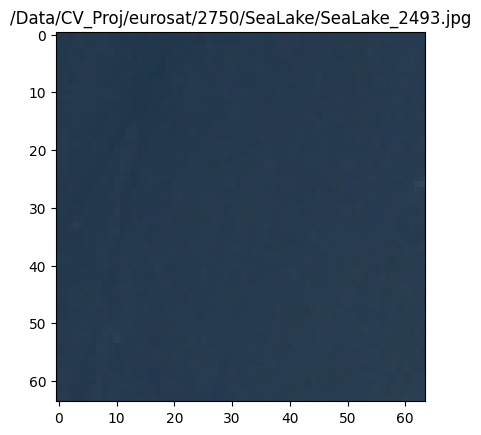

[('AnnualCrop', 7.183091656770557e-05), ('Forest', 0.05473775416612625), ('HerbaceousVegetation', 0.0002848705626092851), ('Highway', 0.0001604830176802352), ('Industrial', 3.881800512317568e-05), ('Pasture', 0.00019905215594917536), ('PermanentCrop', 2.37097883655224e-05), ('Residential', 3.222025770810433e-05), ('River', 0.005554635543376207), ('SeaLake', 0.9388965964317322)]
('SeaLake', 0.9388965964317322)


In [47]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/SeaLake/SeaLake_2493.jpg", 
          plot=True)

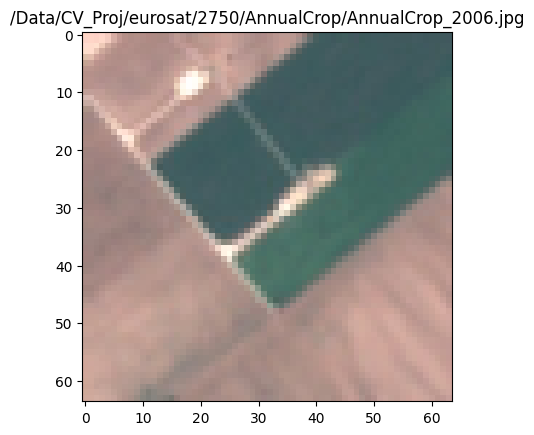

[('AnnualCrop', 0.9530089497566223), ('Forest', 3.5791329082712764e-06), ('HerbaceousVegetation', 8.227676516980864e-06), ('Highway', 0.004948758520185947), ('Industrial', 0.0001612428022781387), ('Pasture', 0.0027370068710297346), ('PermanentCrop', 0.03891909867525101), ('Residential', 1.1596368494792841e-05), ('River', 0.00019964200328104198), ('SeaLake', 2.0033278360642726e-06)]
('AnnualCrop', 0.9530089497566223)


In [48]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/AnnualCrop/AnnualCrop_2006.jpg", 
          plot=True)

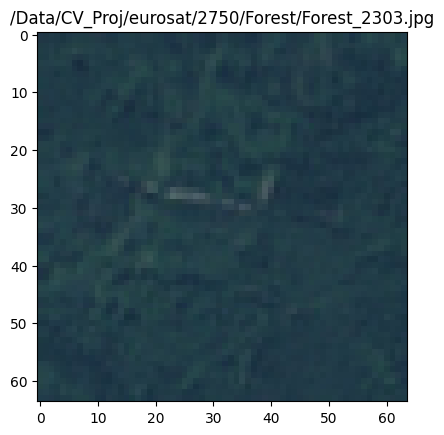

[('AnnualCrop', 0.00011441289098002017), ('Forest', 0.7210730910301208), ('HerbaceousVegetation', 0.06465984880924225), ('Highway', 0.0017988682957366109), ('Industrial', 0.04239719733595848), ('Pasture', 0.09988892078399658), ('PermanentCrop', 0.05098991096019745), ('Residential', 0.01710500754415989), ('River', 0.0007568958681076765), ('SeaLake', 0.0012158445315435529)]
('Forest', 0.7210730910301208)


In [57]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/Forest/Forest_2303.jpg", 
          plot=True)

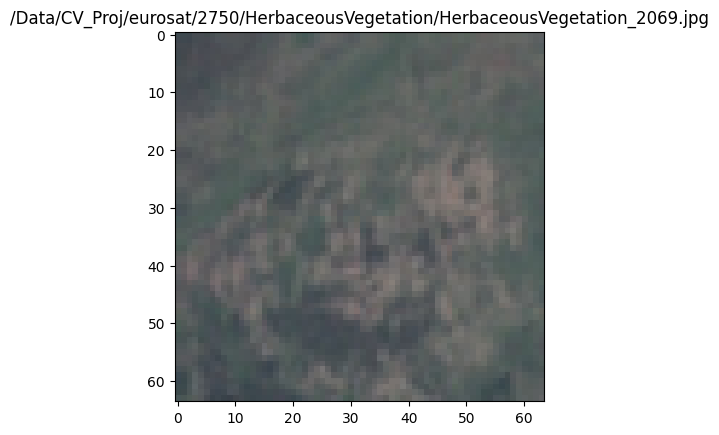

[('AnnualCrop', 1.0206924343947321e-05), ('Forest', 0.17128467559814453), ('HerbaceousVegetation', 0.7921407222747803), ('Highway', 0.0009627845720387995), ('Industrial', 0.0001925565447891131), ('Pasture', 0.014661774039268494), ('PermanentCrop', 0.016413317993283272), ('Residential', 0.0030023204162716866), ('River', 0.0001247076434083283), ('SeaLake', 0.0012068760115653276)]
('HerbaceousVegetation', 0.7921407222747803)


In [59]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/HerbaceousVegetation/HerbaceousVegetation_2069.jpg", 
          plot=True)

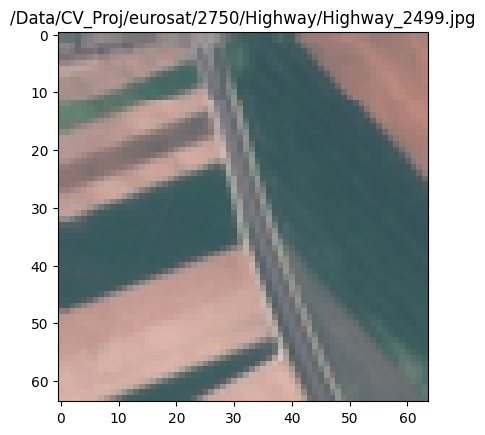

[('AnnualCrop', 0.20553137362003326), ('Forest', 2.3764197720765878e-08), ('HerbaceousVegetation', 7.521601901316899e-07), ('Highway', 0.7713062763214111), ('Industrial', 9.46913985444553e-07), ('Pasture', 5.763628450949909e-06), ('PermanentCrop', 0.00023073991178534925), ('Residential', 6.196265189828409e-07), ('River', 0.022923290729522705), ('SeaLake', 1.5637893113762402e-07)]
('Highway', 0.7713062763214111)


In [61]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/Highway/Highway_2499.jpg", 
          plot=True)

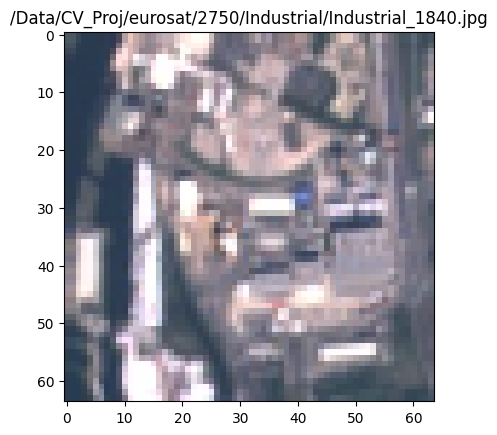

[('AnnualCrop', 1.6565192026973818e-06), ('Forest', 1.0666073649190366e-05), ('HerbaceousVegetation', 3.0315899493871257e-05), ('Highway', 0.0028153855819255114), ('Industrial', 0.9938097596168518), ('Pasture', 8.325495400640648e-06), ('PermanentCrop', 0.003136326791718602), ('Residential', 2.0046836652909406e-05), ('River', 3.861749064526521e-05), ('SeaLake', 0.00012892363884020597)]
('Industrial', 0.9938097596168518)


In [62]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/Industrial/Industrial_1840.jpg", 
          plot=True)

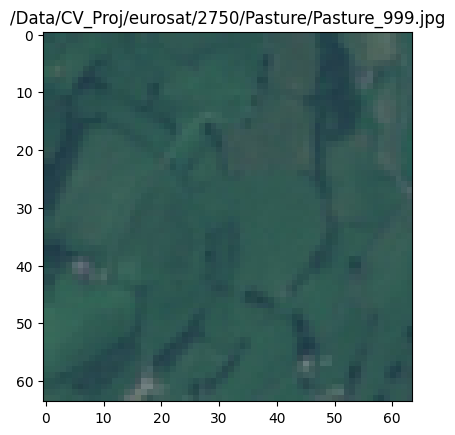

[('AnnualCrop', 7.142476533772424e-05), ('Forest', 0.0017005803529173136), ('HerbaceousVegetation', 0.0006799606489948928), ('Highway', 0.0009305969579145312), ('Industrial', 5.403211252996698e-05), ('Pasture', 0.9923272728919983), ('PermanentCrop', 0.0025790028739720583), ('Residential', 0.0006394941010512412), ('River', 0.00068166374694556), ('SeaLake', 0.00033585491473786533)]
('Pasture', 0.9923272728919983)


In [66]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/Pasture/Pasture_999.jpg", 
          plot=True)

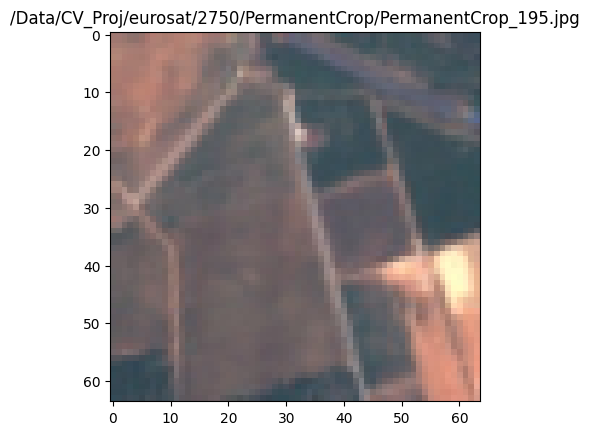

[('AnnualCrop', 0.011189492419362068), ('Forest', 4.118260767427273e-05), ('HerbaceousVegetation', 0.0003763259155675769), ('Highway', 0.032220713794231415), ('Industrial', 0.001844447455368936), ('Pasture', 0.0035623316653072834), ('PermanentCrop', 0.9502043128013611), ('Residential', 0.0001533164904685691), ('River', 0.0004025546077173203), ('SeaLake', 5.415848136181012e-06)]
('PermanentCrop', 0.9502043128013611)


In [67]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/PermanentCrop/PermanentCrop_195.jpg", 
          plot=True)

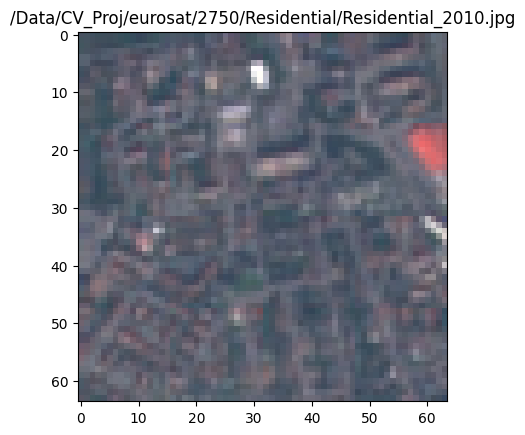

[('AnnualCrop', 5.816972930006159e-07), ('Forest', 3.582947465474717e-05), ('HerbaceousVegetation', 4.854352664551698e-05), ('Highway', 0.00010359577572671697), ('Industrial', 0.0020931363105773926), ('Pasture', 1.8737109712674282e-05), ('PermanentCrop', 0.032150909304618835), ('Residential', 0.9655396938323975), ('River', 8.242060175689403e-06), ('SeaLake', 7.09469588855427e-07)]
('Residential', 0.9655396938323975)


In [68]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/Residential/Residential_2010.jpg", 
          plot=True)

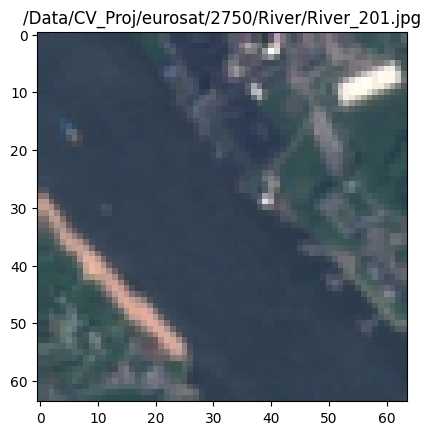

[('AnnualCrop', 0.00018128345254808664), ('Forest', 0.0031833371613174677), ('HerbaceousVegetation', 0.004189325030893087), ('Highway', 0.018537499010562897), ('Industrial', 0.01960272528231144), ('Pasture', 0.0364767350256443), ('PermanentCrop', 0.005320354830473661), ('Residential', 0.007844563573598862), ('River', 0.9032259583473206), ('SeaLake', 0.001438183942809701)]
('River', 0.9032259583473206)


In [70]:
inference(trainer, 
          "/Data/CV_Proj/eurosat/2750/River/River_201.jpg", 
          plot=True)

### Test

In [41]:
import os
import torch
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [42]:
# Define a simple dataset class
class EuroSATDataset(Dataset):
    def __init__(self, file_paths, labels, preprocess):
        self.file_paths = file_paths
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(file_path).convert("RGB")
        if self.preprocess:
            image = self.preprocess(image)
        return image, label

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [44]:
# Define EuroSAT class names
eu_sat_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                  'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
class_to_index = {cls: index for index, cls in enumerate(eu_sat_classes)}

In [45]:
# Load and split the EuroSAT dataset
eu_sat_dir = '/Data/CV_Proj/eurosat/2750'

test_files = []
test_labels = []

for cls in eu_sat_classes:
    cls_dir = os.path.join(eu_sat_dir, cls.replace(' ', '_'))
    filenames = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # random.shuffle(filenames)  # Shuffle the filenames
    test_files.extend(filenames[:])  # Whole dataset for testing
    test_labels.extend([class_to_index[cls]] * len(filenames[:]))

# Create dataset objects for each split
test_dataset = EuroSATDataset(test_files, test_labels, preprocess)

# Create data loaders for each split
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Result for no CSC

In [46]:
# Evaluation with the best model
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = trainer.model_inference(images)
        predicted = outputs.argmax(dim=1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report and confusion matrix
print("Classification Report on Test Set:")
print(classification_report(all_labels, all_predictions, target_names=eu_sat_classes))

Testing: 100%|██████████| 844/844 [28:56<00:00,  2.06s/it]

Classification Report on Test Set:
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.77      0.84      3000
              Forest       0.86      0.94      0.90      3000
HerbaceousVegetation       0.92      0.74      0.82      3000
             Highway       0.72      0.69      0.70      2500
          Industrial       0.87      0.97      0.92      2500
             Pasture       0.73      0.86      0.79      2000
       PermanentCrop       0.68      0.88      0.77      2500
         Residential       0.97      0.91      0.94      3000
               River       0.72      0.69      0.71      2500
             SeaLake       0.97      0.91      0.94      3000

            accuracy                           0.84     27000
           macro avg       0.84      0.84      0.83     27000
        weighted avg       0.85      0.84      0.84     27000



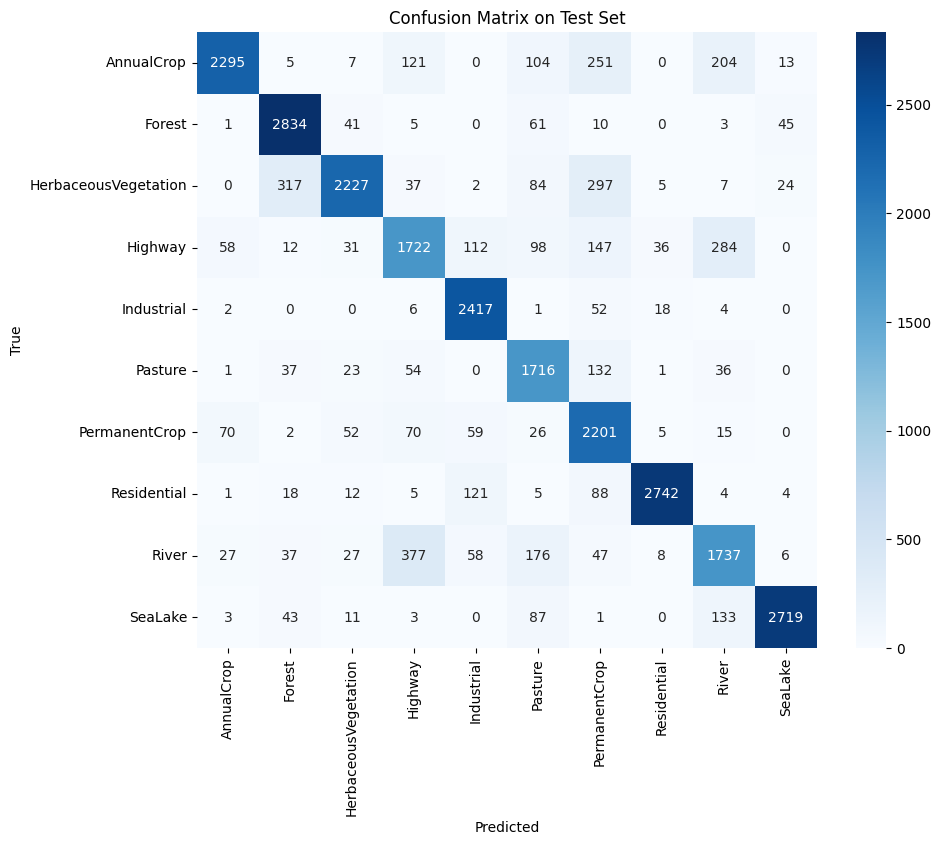

In [47]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=eu_sat_classes, yticklabels=eu_sat_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

### Result for CSC

In [56]:
# Evaluation with the best model
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = trainer.model_inference(images)
        predicted = outputs.argmax(dim=1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report and confusion matrix
print("Classification Report on Test Set:")
print(classification_report(all_labels, all_predictions, target_names=eu_sat_classes))

Testing: 100%|██████████| 844/844 [29:06<00:00,  2.07s/it]

Classification Report on Test Set:
                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.74      0.83      3000
              Forest       0.86      0.96      0.91      3000
HerbaceousVegetation       0.91      0.74      0.82      3000
             Highway       0.70      0.67      0.69      2500
          Industrial       0.89      0.96      0.92      2500
             Pasture       0.75      0.91      0.82      2000
       PermanentCrop       0.73      0.89      0.80      2500
         Residential       0.95      0.93      0.94      3000
               River       0.69      0.68      0.69      2500
             SeaLake       0.97      0.92      0.95      3000

            accuracy                           0.84     27000
           macro avg       0.84      0.84      0.84     27000
        weighted avg       0.85      0.84      0.84     27000



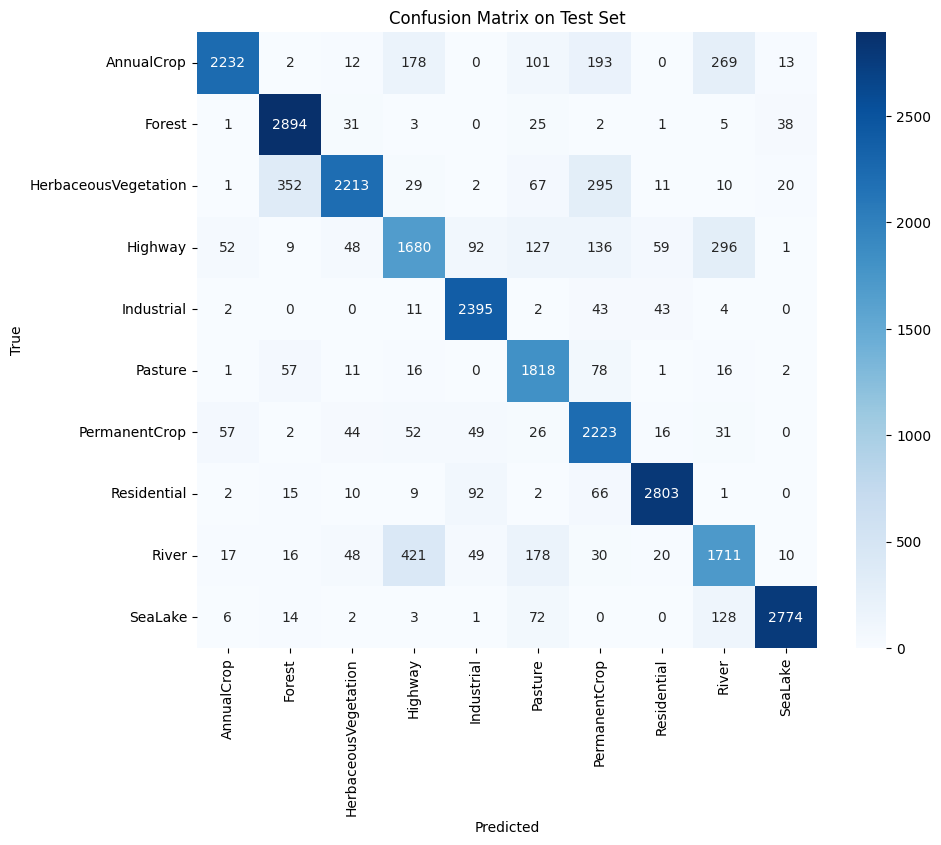

In [57]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=eu_sat_classes, yticklabels=eu_sat_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()